# L3: Kinetic Proofreading

## Overview

There are many systems in biology where a process needs to be completed with high-fidelity. These processes include DNA replication, mRNA translation into proteins, and immune system recognition of infectious molecules. Conceptually, these processes can often be described based on the process of some protein binding some substrate (another protein or a metabolite). Biological systems can tune their specificity for these processes by binding the target substrate with a higher affinity than the off target substrate. However, this difference in affinity is typically not great enough to provide the necessary specificity. To decrease the error rate of these processes it has been hypothesized that biological systems could employ a "proofreading" step where they check to make sure the correct substrate is bound. Hopfield [1974] proposed a molecular mechanism for such proof reading and developed a simple model for how it could work based on the kinetics of chemical reactions.

In this notebook, we will review some of the key assumptions made by Hopfield in the original paper. We will then implement a dynamical model of the kinetic proofreading scheme and tune the parameters to better understand the conditions that lead to improvements in error rate.

In [31]:
%reset
# this command will reset all of the variables in your notebook. 
# After you run this cell you will need to type y and then hit enter

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [1]:
# Imports
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### Introduction

The Hopfield paper starts with a motivational statement that errors in biological systems are observed at very low rates. 1 in 10<sup>4</sup> for protein translation or 1 in 10<sup>9</sup> for DNA replication. This is in stark contrast to the error rate that can be acheived simply from the equilibrium binding of the relevant substrates for these processes. This equilibrium based error rate can be estimated from the thermodynamic properties of the two substrates.

Given two substrates $C$ and $D$ where $C$ is the correct substrate. The thermodynamic equilibrium binding of the system can be described by $\Delta G_{CD}$ which is the difference in the Gibbs free energy of C binding v.s. D binding. The error rate can then be caclulated as the equilibrium concentrations of the binding process $f = exp(-\Delta G_{CD}/RT)$. Where $R$ is the gas constant and $T$ is the temperature. For a more in depth discussion of the relationship between thermodynamics and equilibrium concentrations review Klipp 4.1.3.

From this equation, $f = exp(-\Delta G_{CD}/RT)$, Hopfield estimates that the Gibbs free energy difference $\Delta G_{CD}$ required to acheive the necessary error rate would be around 5.5 kcal or 23 kJ. This calculation can be made for different error rates by solving for $\Delta G_{CD}$.

$\Delta G_{CD}=-ln(f)*RT$

Below, we will use a code cell to implement this calculation. To see if we get the same result as Hopfield.

In [2]:
f = 1/10**4 # error rate
R = 8.3145 # J/(mol*K) the ideal gas constant
T = 298 # K room temperature in Kelvin

Delta_G_CD = -1*np.log(f)*R*T/1000 #required free energy difference (kJ/mol)

# convert to kcal
Delta_G_CD_kcal = Delta_G_CD*0.239

print('Error Rate:',f,'; Free Energy Difference:',np.round(Delta_G_CD,3),'kJ per mol, ',np.round(Delta_G_CD_kcal,3),'kcal per mol')

Error Rate: 0.0001 ; Free Energy Difference: 22.821 kJ per mol,  5.454 kcal per mol


#### QUESTIONS 1, 2:

Let's implement this calculation for different error rates, to see what the necesarry difference in Gibbs free energy would be. One biological system that utilizes kinetic proofreading is the immune system. T-cell receptors use this process to improve the specificity with which they identify foreign antigens (Alon section 9.3). In this system T-cells have an error rate of recognizing self from non-self less than 10<sup>-6</sup>, although the foriegn antigen often has only 10 times higher affinity for the receptor than the self-proteins. Thus at equilibrium the error rate would theoretically only be 1/10.

1. Given a theoretical equilibrium error rate of 1/10, what is the corresponding $\Delta G_{CD}$ between the target and non-target substrates? This is the actual $\Delta G_{CD}$ of the system.
2. If the system were to achieve an error rate of 10<sup>-6</sup> and recognition was based only on equilibrium dynamics (no kinetic proofreading) what would the required $\Delta G_{CD}$ be?



In [3]:
f = 1/10**6 # error rate
R = 8.3145 # J/(mol*K) the ideal gas constant
T = 298 # K room temperature in Kelvin

Delta_G_CD = -1*np.log(f)*R*T/1000 #required free energy difference (kJ/mol)

# convert to kcal
Delta_G_CD_kcal = Delta_G_CD*0.239

print('Error Rate:',f,'; Free Energy Difference:',np.round(Delta_G_CD,3),
      'kJ per mol, ',np.round(Delta_G_CD_kcal,3),'kcal per mol')

Error Rate: 1e-06 ; Free Energy Difference: 34.231 kJ per mol,  8.181 kcal per mol


### The Michaelis Menten Kinetics Model

The Hopfield kinteic proofreading framework starts with the familiar Michaelis Menten schematic:

$C + c \underset{k_{C}}{\overset{k'_{C}}{\rightleftharpoons}} Cc \overset{W}{\rightharpoonup} product$

$D + c \underset{k_{D}}{\overset{k'_{D}}{\rightleftharpoons}} Dc \overset{W}{\rightharpoonup} product$

Where C or D are the correct and incorrect substrates. Hopfield further simplifies this model by assuming that the enzyme acts on C and D with the same rate $W$, and that the on rates for C and D are the same $k'_{C}=k'_{D}$. Thus, any discrimination between the two is entirely dependent on the off rates $k_{C}$ and $k_{D}$.

Derivation of Michaelis Menten error rate ($f$):

$\frac{d[cC]}{dt} = [c][C]k'_{C}-[Cc]k_{C}-[Cc]W=0$ (quasi steady-state approximation)

$[Cc] = \frac{[C][c]k'_{C}}{k_{C}+W}$

$[Dc] = \frac{[D][c]k'_{D}}{k_{D}+W}$

note that $[c]$ can cancel out here so we don't need to envoke the total enzyme constraint from our Michaelis Menten derivation.

$\frac{dP_{C}}{dt} = [Cc]W$

$f = \frac{\frac{dP_{D}}{dt}}{\frac{dP_{C}}{dt}} = \frac{\frac{[D][c]k'_{D}}{k_{D}+W}*W}{\frac{[C][c]k'_{C}}{k_{C}+W}*W}$

$k'_{D}=k'_{C}$ assume equivalent on-rates

$f = \frac{[D](k_{C}+W)}{[C](k_{D}+W)}$ simplified

HopfielD further assumes that the two substrates are in equal concentration: $[D]=[C]$ to get the equation for the error rate with Michaelis Menten kinteics presented in the paper:

$f = \frac{(k_{C}+W)}{(k_{D}+W)}$


#### QUESTION 3:

3. The error rate includes the rate of product formation or speed ($W$) also referred to as the $K_{cat}$ in typical Michaelis Menten kinetics. Through this term, the equation above tells us about the relationship between speed and error rate.
    * a. What is the error rate as $W$ goes to infinity?
    * b. What is the error rate as $W$ goes to 0?
    * c. Include a plot of error rate $f$ as a function of $W$ to illustrate your answers. Plot the speed $W$ on a log scale. Make sure you define $k_C$ and $k_D$ such that the correct substrate has lower off rate.

Hint: To define and plot $W$ on a log scale you can use the numpy command np.logspace to generate a sequential vector in a log base 10 space and pyplot command plt.xscale('log') to set the x axis to a log scale.

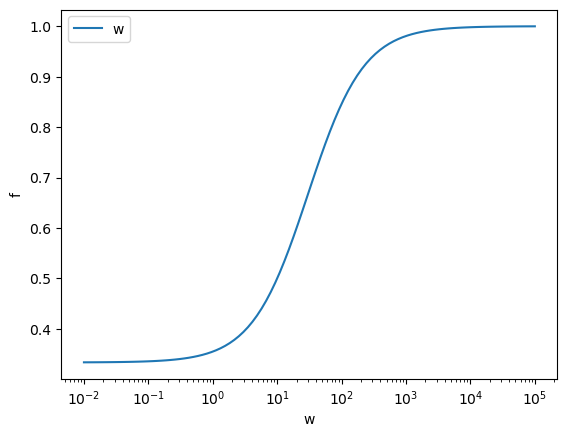

In [4]:
plt.xscale('log')

# kc and kd are off rates, kd > kc
kc = 10
kd = 30

def f(w):
    return (kc + w) / (kd + w) 

w = np.logspace(-2, 5, 100) # returns an array

plt.plot(w, f(w))
plt.xlabel('w')
plt.ylabel('f')
plt.legend(['w','f']);

### The Kinetic Proofreading Model

Hopfield introduced a kinetic model for how a system of enzymes could function (out of equilibrium) to acheive a proof-reading mechanism. The basic idea is that energy is input into the system to "reset" the discriminatory power of the difference in equilibrium binding. Theoretically, this mechanism can lead to decreases in error rate from $f$ to $f^{2}$, with even further theoretical increases up to $f^{n}$ if n proofreading steps are implemented.

Hopfield sets up the following reaction scheme:

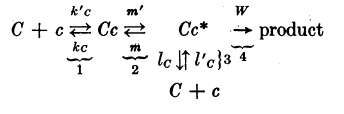

Below we will develop the general differential equations modeling this system and implement numerical simulations to explore their properties.

In [5]:
# Differential Equations for Kinetic Proofreading Scheme

def KP_dynamics(t,y,kC_on,kC_off,kD_on,kD_off,mC,mC_r,mD,mD_r,lC_on,lC_off,lD_on,lD_off,w,w_r,c_total):
    #y[0] = [C] correct substrate
    #y[1] = [D] incorrect substrate
    #y[2] = [Cc] correct enzyme substrate complex
    #y[3] = [Dc] incorrect enzyme substrate complex
    #y[4] = [Cc*] correct enzyme substrate complex *modified
    #y[5] = [Dc*] incorrect enzyme substrate complex *modified
    #y[6] = [PC] correct product
    #y[7] = [PD] incorrect product
    
    # c = c_total - (Cc + Dc + Cc* + Dc*)
    
    dydt = np.zeros(8)    
    
    # constant concentrations of substrates
    dydt[0] = 0
    dydt[1] = 0
    # for a batch simulation with dynamics on the substrate concentrations use the following:
    #dydt[0] = y[2]*kC_off + y[4]*lC_off - y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]))*(kC_on+lC_on)
    #dydt[1] = y[3]*kD_off + y[5]*lD_off - y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]))*(kD_on+lD_on)
    
    dydt[2] = y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]))*kC_on + y[4]*mC_r - y[2]*(kC_off+mC)
    dydt[3] = y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]))*kD_on + y[5]*mD_r - y[3]*(kD_off+mD)
    dydt[4] = y[0]*(c_total-(y[2]+y[3]+y[4]+y[5]))*lC_on + y[2]*mC + y[6]*w_r - y[4]*(mC_r+lC_off+w)
    dydt[5] = y[1]*(c_total-(y[2]+y[3]+y[4]+y[5]))*lD_on + y[3]*mD + y[7]*w_r - y[5]*(mD_r+lD_off+w)
    dydt[6] = y[4]*w - y[6]*w_r
    dydt[7] = y[5]*w - y[7]*w_r
    
    return dydt

At equilibrium the parameters are constrained by equation 6 of Hopfield et al. The parameters are defined below with several simplifying assumptions and this constraint taken into consideration. The following code will then simulate the dynamics of the resulting kinetic system.

/var/folders/d4/h_3qq8gj29g96wsk1c58hb4m0000gn/T/ipykernel_16449/2381559604.py:60: RuntimeWarning: invalid value encountered in divide
  f = dPDdt/dPCdt


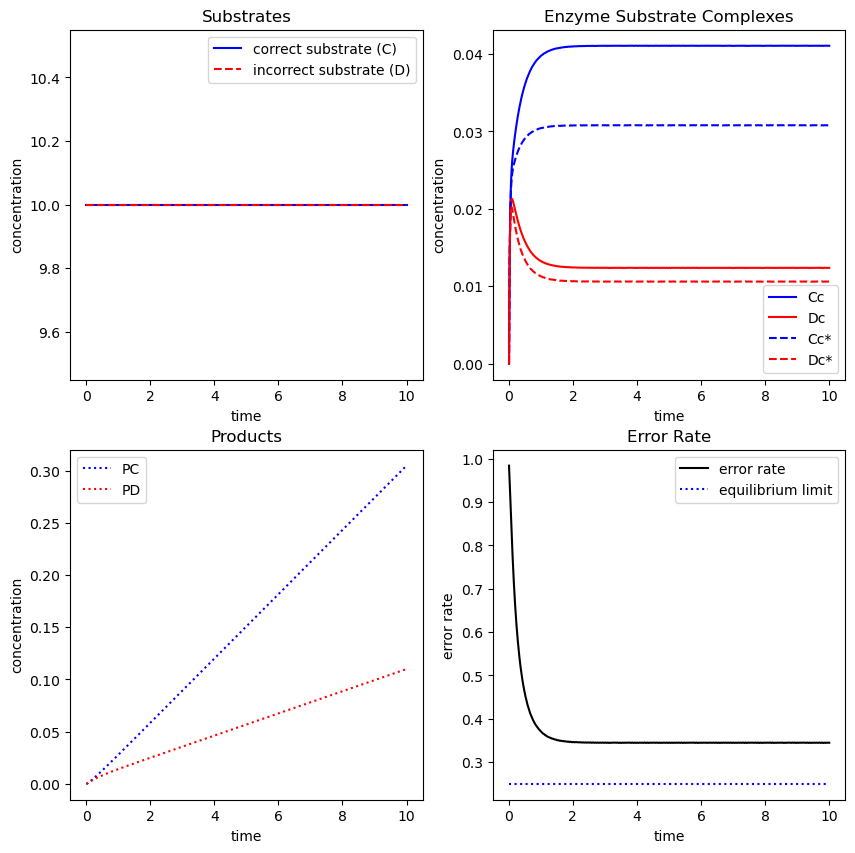

In [6]:
# Parameters
kC_on = 1
kC_off = 1
kD_on = kC_on #equal on-rate assumption
kD_off = 4
lC_on = kC_on #for simplicity
lC_off = kC_off #for simplicity
lD_on = lC_on #equal on-rate assumption
lD_off = kD_off #for simplicity
mC = 1
mC_r = mC*(kC_on*lC_off)/(kC_off*lC_on) #equlibrium constraint from Hopfield equation 6
mD = mC
mD_r = mC_r
w = 1
w_r = 0
c_total = 0.1 #total enzyme

# Initial Conditions
C0 = 10 # Initial C
D0 = 10 # Initial D
y0 = [C0,D0,0,0,0,0,0,0]

# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics(t,y,kC_on,kC_off,kD_on,kD_off,mC,mC_r,mD,mD_r,lC_on,lC_off,lD_on,lD_off,w,w_r,c_total),tspan,y0,t_eval=t)

# Plot
fig,axs = plt.subplots(2,2,figsize=(10, 10))

axs[0,0].set_title('Substrates')
axs[0,0].plot(t,ode_sol.y[0],'b-')
axs[0,0].plot(t,ode_sol.y[1],'r--')
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('concentration')
axs[0,0].legend(['correct substrate (C)','incorrect substrate (D)']);

axs[0,1].set_title('Enzyme Substrate Complexes')
axs[0,1].plot(t,ode_sol.y[2],'b-')
axs[0,1].plot(t,ode_sol.y[3],'r-')
axs[0,1].plot(t,ode_sol.y[4],'b--')
axs[0,1].plot(t,ode_sol.y[5],'r--')
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('concentration')
axs[0,1].legend(['Cc','Dc','Cc*','Dc*']);

axs[1,0].set_title('Products')
axs[1,0].plot(t,ode_sol.y[6],'b:')
axs[1,0].plot(t,ode_sol.y[7],'r:')
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('concentration')
axs[1,0].legend(['PC','PD']);

axs[1,1].set_title('Error Rate')
st = 1
dPCdt = ode_sol.y[4]*w - ode_sol.y[6]*w_r
dPDdt = ode_sol.y[5]*w - ode_sol.y[7]*w_r
f = dPDdt/dPCdt
axs[1,1].plot(t[st:],f[st:],'k')
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('error rate')

# theoretical minimum error rate at equilibrium
f_MM_limit = (D0*kC_off)/(C0*kD_off)
axs[1,1].plot([t[st],t[-1]],[f_MM_limit,f_MM_limit],'b:')
axs[1,1].legend(['error rate','equilibrium limit']);

### Adjust the Speed

#### QUESTION 4:
4. Copy the code above and adjust the speed of the reaction by changing the parameter w. Note: do not change the parameter w_r from 0 or the reaction will reach complete equilibrium making the error rate calculation impossible. Try running the simulation for several different speeds and briefly describe how the speed impacts the final error rate.

/var/folders/d4/h_3qq8gj29g96wsk1c58hb4m0000gn/T/ipykernel_16449/726057306.py:60: RuntimeWarning: invalid value encountered in divide
  f = dPDdt/dPCdt


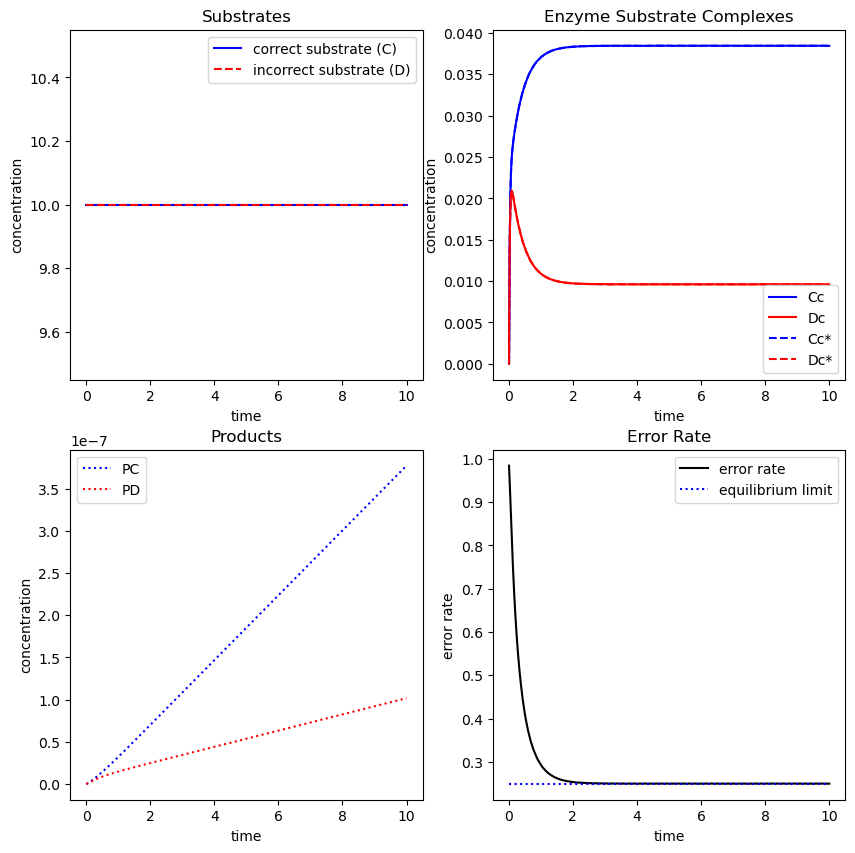

In [7]:
# Parameters
kC_on = 1
kC_off = 1
kD_on = kC_on #equal on-rate assumption
kD_off = 4
lC_on = kC_on #for simplicity
lC_off = kC_off #for simplicity
lD_on = lC_on #equal on-rate assumption
lD_off = kD_off #for simplicity
mC = 1
mC_r = mC*(kC_on*lC_off)/(kC_off*lC_on) #equlibrium constraint from Hopfield equation 6
mD = mC
mD_r = mC_r
w = 1/10 ** 6
w_r = 0
c_total = 0.1 #total enzyme

# Initial Conditions
C0 = 10 # Initial C
D0 = 10 # Initial D
y0 = [C0,D0,0,0,0,0,0,0]

# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics(t,y,kC_on,kC_off,kD_on,kD_off,mC,mC_r,mD,mD_r,lC_on,lC_off,lD_on,lD_off,w,w_r,c_total),tspan,y0,t_eval=t)

# Plot
fig,axs = plt.subplots(2,2,figsize=(10, 10))

axs[0,0].set_title('Substrates')
axs[0,0].plot(t,ode_sol.y[0],'b-')
axs[0,0].plot(t,ode_sol.y[1],'r--')
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('concentration')
axs[0,0].legend(['correct substrate (C)','incorrect substrate (D)']);

axs[0,1].set_title('Enzyme Substrate Complexes')
axs[0,1].plot(t,ode_sol.y[2],'b-')
axs[0,1].plot(t,ode_sol.y[3],'r-')
axs[0,1].plot(t,ode_sol.y[4],'b--')
axs[0,1].plot(t,ode_sol.y[5],'r--')
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('concentration')
axs[0,1].legend(['Cc','Dc','Cc*','Dc*']);

axs[1,0].set_title('Products')
axs[1,0].plot(t,ode_sol.y[6],'b:')
axs[1,0].plot(t,ode_sol.y[7],'r:')
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('concentration')
axs[1,0].legend(['PC','PD']);

axs[1,1].set_title('Error Rate')
st = 1
dPCdt = ode_sol.y[4]*w - ode_sol.y[6]*w_r
dPDdt = ode_sol.y[5]*w - ode_sol.y[7]*w_r
f = dPDdt/dPCdt
axs[1,1].plot(t[st:],f[st:],'k')
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('error rate')

# theoretical minimum error rate at equilibrium
f_MM_limit = (D0*kC_off)/(C0*kD_off)
axs[1,1].plot([t[st],t[-1]],[f_MM_limit,f_MM_limit],'b:')
axs[1,1].legend(['error rate','equilibrium limit']);

### Just Add Energy

Hopfield makes the argument that energy is required for this system to drive error rates below the equilibrium limit. The error rate can be improved by adding energy to selected steps in the kinetic scheme and driving them forward (without any regard to the correct or incorrect substrates!). This energy is generally coupled to reaction 2 and under the ideal Kinetic Proofreading reacting scheme both reaction 2 and 3 are coupled to an energy source making them essentially irreversible. The resulting reaction scheme is presented below.

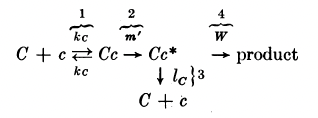

In this kinetic proofreading scheme the error rate is given by:

$f = \frac{[D](k_{C}+m')(l_{C}+W)}{[C](k_{D}+m')(l_{D}+W)}$

The theoretical kinetic profreading error rate limit is reached when both $W=0$ and $m'=0$ given as:

$f = \frac{[D](k_{C})(l_{C})}{[C](k_{D})(l_{D})}$

#### QUESTIONS 5 and 6:

5. Adapt the code above and modify the parameters to match the ideal proofreading scheme (making steps 2 and 3 irreversible). Hint: Only change the parameters associated with the reversibility of steps 2 and 3. Generate a new plot of the error rate and add a horizontal line indicating the kinetic proofreading error rate limit. Provide your new error rate plot (you may provide all 4 of the plots above or just the error rate plot). Briefly describe your results and the adjustments you made.

6. It may be difficult for cells to make the binding and unbinding step 3 irreversible given that the complexs Cc and Cc* would be relatively similar. Reset the parameters for step 3 to be the same as those for step 1 (as they are in the original simulation). Adjust the speed of the reaction by changing the paramters mC, mC_r and w (Note: you must also keep mD=mC and mD_r=mC_r, and parameters can not be made negative). Under these conditions, what are values of the 3 parameters (mC, mC_r and w) that gets the error rate below the equilibrium limit?

/var/folders/d4/h_3qq8gj29g96wsk1c58hb4m0000gn/T/ipykernel_16449/3602408605.py:64: RuntimeWarning: invalid value encountered in divide
  f = dPDdt/dPCdt


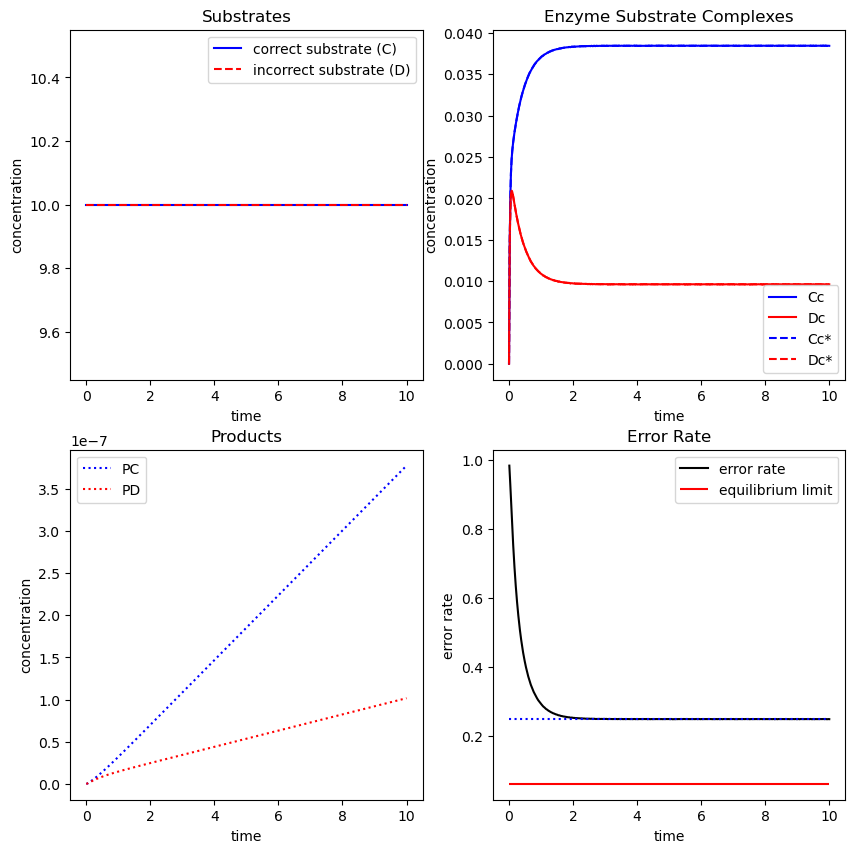

In [11]:
# Parameters
kC_on = 1
kC_off = 1
kD_on = kC_on #equal on-rate assumption
kD_off = 4
lC_on = kC_on #for simplicity
lC_off = kC_off #for simplicity
lD_on = lC_on #equal on-rate assumption
lD_off = kD_off #for simplicity
mC = 0
mC_r = mC*(kC_on*lC_off)/(kC_off*lC_on) #equlibrium constraint from Hopfield equation 6
# mC_r = 0 # make step 2 irreversible
mD = mC
mD_r = mC_r
w = 1/10 ** 6
w_r = 0
c_total = 0.1 #total enzyme

def erl(c = .001, d = .001):
    return (d * kC_off * lC_off) / (c * kD_off * lD_off)

# Initial Conditions
C0 = 10 # Initial C
D0 = 10 # Initial D
y0 = [C0,D0,0,0,0,0,0,0]

# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics(t,y,kC_on,kC_off,kD_on,kD_off,mC,mC_r,mD,mD_r,lC_on,lC_off,lD_on,lD_off,w,w_r,c_total),tspan,y0,t_eval=t)

# Plot
fig,axs = plt.subplots(2,2,figsize=(10, 10))

axs[0,0].set_title('Substrates')
axs[0,0].plot(t,ode_sol.y[0],'b-')
axs[0,0].plot(t,ode_sol.y[1],'r--')
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('concentration')
axs[0,0].legend(['correct substrate (C)','incorrect substrate (D)']);

axs[0,1].set_title('Enzyme Substrate Complexes')
axs[0,1].plot(t,ode_sol.y[2],'b-')
axs[0,1].plot(t,ode_sol.y[3],'r-')
axs[0,1].plot(t,ode_sol.y[4],'b--')
axs[0,1].plot(t,ode_sol.y[5],'r--')
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('concentration')
axs[0,1].legend(['Cc','Dc','Cc*','Dc*']);

axs[1,0].set_title('Products')
axs[1,0].plot(t,ode_sol.y[6],'b:')
axs[1,0].plot(t,ode_sol.y[7],'r:')
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('concentration')
axs[1,0].legend(['PC','PD']);

axs[1,1].set_title('Error Rate')
st = 1
dPCdt = ode_sol.y[4]*w - ode_sol.y[6]*w_r
dPDdt = ode_sol.y[5]*w - ode_sol.y[7]*w_r
f = dPDdt/dPCdt
axs[1,1].plot(t[st:],f[st:],'k')
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('error rate')
# horizontal line for error rate limit
axs[1,1].hlines(erl(),0,10, "r")

# theoretical minimum error rate at equilibrium
f_MM_limit = (D0*kC_off)/(C0*kD_off)
axs[1,1].plot([t[st],t[-1]],[f_MM_limit,f_MM_limit],'b:')
axs[1,1].legend(['error rate','equilibrium limit']);

/var/folders/d4/h_3qq8gj29g96wsk1c58hb4m0000gn/T/ipykernel_16449/665497059.py:60: RuntimeWarning: invalid value encountered in divide
  f = dPDdt/dPCdt


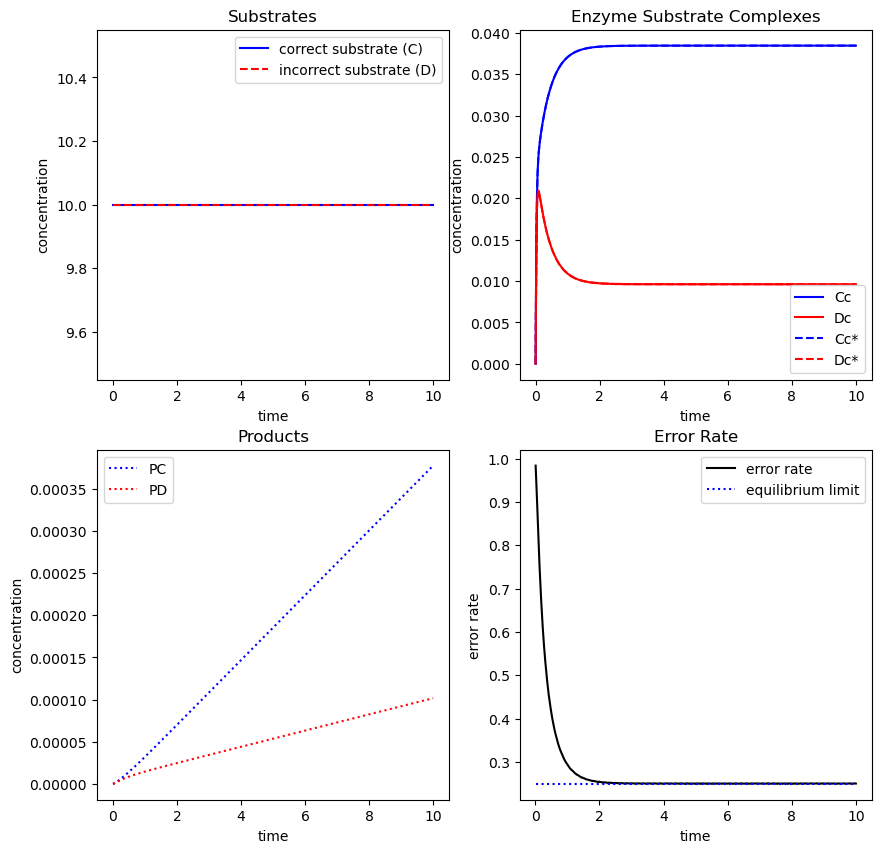

In [26]:
# Parameters
kC_on = 1
kC_off = 1
kD_on = kC_on #equal on-rate assumption
kD_off = 4
lC_on = kC_on #for simplicity
lC_off = kC_off #for simplicity
lD_on = lC_on #equal on-rate assumption
lD_off = kD_off #for simplicity
mC = 1e3
mC_r = mC*(kC_on*lC_off)/(kC_off*lC_on) #equlibrium constraint from Hopfield equation 6
mD = mC
mD_r = mC_r
w = 1e-3
w_r = 0
c_total = 0.1 #total enzyme

# Initial Conditions
C0 = 10 # Initial C
D0 = 10 # Initial D
y0 = [C0,D0,0,0,0,0,0,0]

# time span
t = np.linspace(0,10,1000)
tspan = [t[0],t[-1]]

# Solve
ode_sol = solve_ivp(lambda t,y:KP_dynamics(t,y,kC_on,kC_off,kD_on,kD_off,mC,mC_r,mD,mD_r,lC_on,lC_off,lD_on,lD_off,w,w_r,c_total),tspan,y0,t_eval=t)

# Plot
fig,axs = plt.subplots(2,2,figsize=(10, 10))

axs[0,0].set_title('Substrates')
axs[0,0].plot(t,ode_sol.y[0],'b-')
axs[0,0].plot(t,ode_sol.y[1],'r--')
axs[0,0].set_xlabel('time')
axs[0,0].set_ylabel('concentration')
axs[0,0].legend(['correct substrate (C)','incorrect substrate (D)']);

axs[0,1].set_title('Enzyme Substrate Complexes')
axs[0,1].plot(t,ode_sol.y[2],'b-')
axs[0,1].plot(t,ode_sol.y[3],'r-')
axs[0,1].plot(t,ode_sol.y[4],'b--')
axs[0,1].plot(t,ode_sol.y[5],'r--')
axs[0,1].set_xlabel('time')
axs[0,1].set_ylabel('concentration')
axs[0,1].legend(['Cc','Dc','Cc*','Dc*']);

axs[1,0].set_title('Products')
axs[1,0].plot(t,ode_sol.y[6],'b:')
axs[1,0].plot(t,ode_sol.y[7],'r:')
axs[1,0].set_xlabel('time')
axs[1,0].set_ylabel('concentration')
axs[1,0].legend(['PC','PD']);

axs[1,1].set_title('Error Rate')
st = 1
dPCdt = ode_sol.y[4]*w - ode_sol.y[6]*w_r
dPDdt = ode_sol.y[5]*w - ode_sol.y[7]*w_r
f = dPDdt/dPCdt
axs[1,1].plot(t[st:],f[st:],'k')
axs[1,1].set_xlabel('time')
axs[1,1].set_ylabel('error rate')

# theoretical minimum error rate at equilibrium
f_MM_limit = (D0*kC_off)/(C0*kD_off)
axs[1,1].plot([t[st],t[-1]],[f_MM_limit,f_MM_limit],'b:')
axs[1,1].legend(['error rate','equilibrium limit']);